# SRGAN

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
from data import DIV2K
from model.srgan import SRGAN, Discriminator
from train import SrganTrainer, SrganGeneratorTrainer

%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
seed_value = 1234
tf.random.set_seed(seed_value)

In [3]:
# Location of model weights (needed for demo)
weights_dir = 'weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [4]:
div2k_train = DIV2K(scale=4, subset='train', downgrade='bicubic')
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')

In [5]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-srgan.tar.gz](https://martin-krasser.de/sisr/weights-srgan.tar.gz) and extract the archive in the project's root directory. This will create a folder `weights/srgan` containing the weights of the pre-trained models.

### Generator pre-training

In [6]:
generator = SRGAN()

In [7]:
pre_trainer = SrganGeneratorTrainer(model=generator, checkpoint_dir=f'.ckpt/pre_generator')
pre_trainer.train(train_ds,
                  valid_ds.take(1000),
                  steps=200000, 
                  evaluate_every=1000, 
                  save_best_only=False)

pre_trainer.model.save_weights(weights_file('pre_generator.h5'))

1000/200000: loss = 706.975, PSNR = 23.397989 (35.25s)
2000/200000: loss = 357.681, PSNR = 24.610395 (24.82s)
3000/200000: loss = 292.034, PSNR = 24.380390 (24.97s)
4000/200000: loss = 264.955, PSNR = 26.057308 (24.74s)
5000/200000: loss = 244.629, PSNR = 24.393734 (24.71s)
6000/200000: loss = 240.625, PSNR = 25.761503 (24.84s)
7000/200000: loss = 224.343, PSNR = 25.387739 (24.69s)
8000/200000: loss = 224.630, PSNR = 26.161854 (24.67s)
9000/200000: loss = 217.687, PSNR = 26.265581 (25.82s)
10000/200000: loss = 210.489, PSNR = 27.059076 (25.69s)
11000/200000: loss = 208.032, PSNR = 26.953852 (25.75s)
12000/200000: loss = 201.119, PSNR = 27.682226 (24.67s)
13000/200000: loss = 203.854, PSNR = 26.888533 (24.93s)
14000/200000: loss = 197.985, PSNR = 27.940674 (24.76s)
15000/200000: loss = 198.709, PSNR = 27.732967 (25.52s)
16000/200000: loss = 194.869, PSNR = 27.935534 (24.84s)
17000/200000: loss = 191.944, PSNR = 28.116880 (24.81s)
18000/200000: loss = 189.488, PSNR = 28.300707 (24.68s)
1

147000/200000: loss = 159.785, PSNR = 29.777861 (24.69s)
148000/200000: loss = 157.872, PSNR = 29.542389 (25.33s)
149000/200000: loss = 160.916, PSNR = 29.188610 (25.82s)
150000/200000: loss = 159.345, PSNR = 28.849989 (25.39s)
151000/200000: loss = 160.749, PSNR = 28.701797 (25.85s)
152000/200000: loss = 156.833, PSNR = 28.590586 (25.39s)
153000/200000: loss = 159.407, PSNR = 29.236856 (25.09s)
154000/200000: loss = 160.054, PSNR = 29.514330 (24.91s)
155000/200000: loss = 160.308, PSNR = 28.605133 (24.97s)
156000/200000: loss = 158.508, PSNR = 29.148228 (24.68s)
157000/200000: loss = 161.628, PSNR = 29.828995 (24.96s)
158000/200000: loss = 160.346, PSNR = 29.897905 (24.83s)
159000/200000: loss = 157.369, PSNR = 29.255449 (24.85s)
160000/200000: loss = 158.296, PSNR = 29.557217 (24.97s)
161000/200000: loss = 160.467, PSNR = 29.452627 (24.82s)
162000/200000: loss = 158.139, PSNR = 29.000347 (24.68s)
163000/200000: loss = 158.831, PSNR = 29.571369 (24.98s)
164000/200000: loss = 156.821, 

In [8]:
pre_trainer.restore()

Model restored from checkpoint at step 200000.


### Generator fine-tuning (GAN)

In [16]:
gan_generator = SRGAN()
discriminator = Discriminator()
gan_generator(tf.ones((1, 24, 24, 3)))
gan_generator.load_weights(weights_file('pre_generator.h5'))

gan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator)
gan_trainer.train(train_ds, steps=50000)

50/50000, perceptual loss = 0.0875, discriminator loss = 1.7483
100/50000, perceptual loss = 0.0831, discriminator loss = 1.3385
150/50000, perceptual loss = 0.0831, discriminator loss = 0.7619
200/50000, perceptual loss = 0.0829, discriminator loss = 1.3081
250/50000, perceptual loss = 0.0868, discriminator loss = 0.7275
300/50000, perceptual loss = 0.0844, discriminator loss = 0.5653
350/50000, perceptual loss = 0.0794, discriminator loss = 0.9162
400/50000, perceptual loss = 0.0767, discriminator loss = 0.6093
450/50000, perceptual loss = 0.0958, discriminator loss = 0.9548
500/50000, perceptual loss = 0.0900, discriminator loss = 0.5127
550/50000, perceptual loss = 0.0814, discriminator loss = 0.6977
600/50000, perceptual loss = 0.0811, discriminator loss = 0.7359
650/50000, perceptual loss = 0.0963, discriminator loss = 0.7334
700/50000, perceptual loss = 0.0923, discriminator loss = 0.5049
750/50000, perceptual loss = 0.0846, discriminator loss = 0.4612
800/50000, perceptual loss

6300/50000, perceptual loss = 0.0852, discriminator loss = 0.4782
6350/50000, perceptual loss = 0.0791, discriminator loss = 0.5205
6400/50000, perceptual loss = 0.0833, discriminator loss = 0.7041
6450/50000, perceptual loss = 0.0790, discriminator loss = 0.3598
6500/50000, perceptual loss = 0.0827, discriminator loss = 0.4299
6550/50000, perceptual loss = 0.0824, discriminator loss = 0.7171
6600/50000, perceptual loss = 0.0785, discriminator loss = 0.2742
6650/50000, perceptual loss = 0.0788, discriminator loss = 0.3194
6700/50000, perceptual loss = 0.0828, discriminator loss = 0.5611
6750/50000, perceptual loss = 0.0782, discriminator loss = 0.4687
6800/50000, perceptual loss = 0.0806, discriminator loss = 0.8262
6850/50000, perceptual loss = 0.0805, discriminator loss = 0.4398
6900/50000, perceptual loss = 0.0878, discriminator loss = 0.3556
6950/50000, perceptual loss = 0.0828, discriminator loss = 0.5626
7000/50000, perceptual loss = 0.0811, discriminator loss = 0.6753
7050/50000

12500/50000, perceptual loss = 0.0822, discriminator loss = 0.5402
12550/50000, perceptual loss = 0.0850, discriminator loss = 0.3571
12600/50000, perceptual loss = 0.0811, discriminator loss = 0.5373
12650/50000, perceptual loss = 0.0832, discriminator loss = 0.2707
12700/50000, perceptual loss = 0.0804, discriminator loss = 0.6141
12750/50000, perceptual loss = 0.0795, discriminator loss = 0.3097
12800/50000, perceptual loss = 0.0790, discriminator loss = 0.4824
12850/50000, perceptual loss = 0.0822, discriminator loss = 0.2919
12900/50000, perceptual loss = 0.0792, discriminator loss = 0.3224
12950/50000, perceptual loss = 0.0826, discriminator loss = 0.3082
13000/50000, perceptual loss = 0.0826, discriminator loss = 0.7863
13050/50000, perceptual loss = 0.0832, discriminator loss = 0.4341
13100/50000, perceptual loss = 0.0790, discriminator loss = 0.5878
13150/50000, perceptual loss = 0.0820, discriminator loss = 0.3798
13200/50000, perceptual loss = 0.0825, discriminator loss = 0.

18650/50000, perceptual loss = 0.0804, discriminator loss = 0.6396
18700/50000, perceptual loss = 0.0789, discriminator loss = 0.2672
18750/50000, perceptual loss = 0.0820, discriminator loss = 0.3314
18800/50000, perceptual loss = 0.0816, discriminator loss = 0.3587
18850/50000, perceptual loss = 0.0815, discriminator loss = 0.5548
18900/50000, perceptual loss = 0.0824, discriminator loss = 0.4338
18950/50000, perceptual loss = 0.0829, discriminator loss = 0.3114
19000/50000, perceptual loss = 0.0804, discriminator loss = 0.5221
19050/50000, perceptual loss = 0.0819, discriminator loss = 0.4786
19100/50000, perceptual loss = 0.0832, discriminator loss = 0.2679
19150/50000, perceptual loss = 0.0797, discriminator loss = 0.4060
19200/50000, perceptual loss = 0.0760, discriminator loss = 0.2964
19250/50000, perceptual loss = 0.0824, discriminator loss = 0.5896
19300/50000, perceptual loss = 0.0784, discriminator loss = 0.4866
19350/50000, perceptual loss = 0.0769, discriminator loss = 0.

24800/50000, perceptual loss = 0.0764, discriminator loss = 0.2344
24850/50000, perceptual loss = 0.0859, discriminator loss = 0.2467
24900/50000, perceptual loss = 0.0796, discriminator loss = 0.3399
24950/50000, perceptual loss = 0.0839, discriminator loss = 0.3796
25000/50000, perceptual loss = 0.0767, discriminator loss = 0.4056
25050/50000, perceptual loss = 0.0788, discriminator loss = 0.5838
25100/50000, perceptual loss = 0.0777, discriminator loss = 0.3118
25150/50000, perceptual loss = 0.0825, discriminator loss = 0.2265
25200/50000, perceptual loss = 0.0804, discriminator loss = 0.1154
25250/50000, perceptual loss = 0.0817, discriminator loss = 0.2144
25300/50000, perceptual loss = 0.0779, discriminator loss = 0.5155
25350/50000, perceptual loss = 0.0796, discriminator loss = 0.3078
25400/50000, perceptual loss = 0.0839, discriminator loss = 0.3947
25450/50000, perceptual loss = 0.0824, discriminator loss = 0.5229
25500/50000, perceptual loss = 0.0844, discriminator loss = 0.

30950/50000, perceptual loss = 0.0792, discriminator loss = 0.2098
31000/50000, perceptual loss = 0.0812, discriminator loss = 0.4961
31050/50000, perceptual loss = 0.0828, discriminator loss = 0.2680
31100/50000, perceptual loss = 0.0833, discriminator loss = 0.2172
31150/50000, perceptual loss = 0.0804, discriminator loss = 0.2922
31200/50000, perceptual loss = 0.0802, discriminator loss = 0.4808
31250/50000, perceptual loss = 0.0800, discriminator loss = 0.2624
31300/50000, perceptual loss = 0.0806, discriminator loss = 0.5085
31350/50000, perceptual loss = 0.0830, discriminator loss = 0.4402
31400/50000, perceptual loss = 0.0770, discriminator loss = 0.2011
31450/50000, perceptual loss = 0.0870, discriminator loss = 0.2202
31500/50000, perceptual loss = 0.0777, discriminator loss = 0.3257
31550/50000, perceptual loss = 0.0819, discriminator loss = 0.3467
31600/50000, perceptual loss = 0.0827, discriminator loss = 0.6387
31650/50000, perceptual loss = 0.0833, discriminator loss = 0.

37100/50000, perceptual loss = 0.0872, discriminator loss = 0.4332
37150/50000, perceptual loss = 0.0801, discriminator loss = 0.4312
37200/50000, perceptual loss = 0.0790, discriminator loss = 0.3771
37250/50000, perceptual loss = 0.0826, discriminator loss = 0.2448
37300/50000, perceptual loss = 0.0792, discriminator loss = 0.2189
37350/50000, perceptual loss = 0.0875, discriminator loss = 0.3798
37400/50000, perceptual loss = 0.0789, discriminator loss = 0.3263
37450/50000, perceptual loss = 0.0852, discriminator loss = 0.1862
37500/50000, perceptual loss = 0.0845, discriminator loss = 0.2145
37550/50000, perceptual loss = 0.0789, discriminator loss = 0.2477
37600/50000, perceptual loss = 0.0801, discriminator loss = 0.1970
37650/50000, perceptual loss = 0.0820, discriminator loss = 0.3343
37700/50000, perceptual loss = 0.0778, discriminator loss = 0.3164
37750/50000, perceptual loss = 0.0809, discriminator loss = 0.3092
37800/50000, perceptual loss = 0.0807, discriminator loss = 0.

43250/50000, perceptual loss = 0.0845, discriminator loss = 0.2306
43300/50000, perceptual loss = 0.0823, discriminator loss = 0.4505
43350/50000, perceptual loss = 0.0836, discriminator loss = 0.4621
43400/50000, perceptual loss = 0.0790, discriminator loss = 0.1572
43450/50000, perceptual loss = 0.0796, discriminator loss = 0.2232
43500/50000, perceptual loss = 0.0791, discriminator loss = 0.2535
43550/50000, perceptual loss = 0.0820, discriminator loss = 0.3895
43600/50000, perceptual loss = 0.0837, discriminator loss = 0.2939
43650/50000, perceptual loss = 0.0828, discriminator loss = 0.4064
43700/50000, perceptual loss = 0.0817, discriminator loss = 0.2693
43750/50000, perceptual loss = 0.0808, discriminator loss = 0.1785
43800/50000, perceptual loss = 0.0818, discriminator loss = 0.2634
43850/50000, perceptual loss = 0.0841, discriminator loss = 0.4491
43900/50000, perceptual loss = 0.0813, discriminator loss = 0.2885
43950/50000, perceptual loss = 0.0805, discriminator loss = 0.

49400/50000, perceptual loss = 0.0794, discriminator loss = 0.1032
49450/50000, perceptual loss = 0.0824, discriminator loss = 0.1761
49500/50000, perceptual loss = 0.0796, discriminator loss = 0.4015
49550/50000, perceptual loss = 0.0760, discriminator loss = 0.2517
49600/50000, perceptual loss = 0.0831, discriminator loss = 0.1963
49650/50000, perceptual loss = 0.0855, discriminator loss = 0.2699
49700/50000, perceptual loss = 0.0800, discriminator loss = 0.2834
49750/50000, perceptual loss = 0.0821, discriminator loss = 0.1460
49800/50000, perceptual loss = 0.0819, discriminator loss = 0.1032
49850/50000, perceptual loss = 0.0822, discriminator loss = 0.2567
49900/50000, perceptual loss = 0.0809, discriminator loss = 0.2282
49950/50000, perceptual loss = 0.0825, discriminator loss = 0.1449
50000/50000, perceptual loss = 0.0884, discriminator loss = 0.2741


In [17]:
gan_trainer.generator.save_weights(weights_file('gan_generator.h5'))
gan_trainer.discriminator.save_weights(weights_file('gan_discriminator.h5'))

## Demo

In [18]:
pre_generator = SRGAN()
pre_generator(tf.ones((1, 24, 24, 3)))
gan_generator = SRGAN()
gan_generator(tf.ones((1, 24, 24, 3)))

pre_generator.load_weights(weights_file('pre_generator.h5'))
gan_generator.load_weights(weights_file('gan_generator.h5'))

In [19]:
from model import resolve_single
from utils import load_image

lr = load_image('demo/0869x4-crop.png')
lr_batch = tf.expand_dims(lr, axis=0)
lr_batch = tf.cast(lr_batch, tf.float32)
sr_batch = generator(lr_batch)
sr_batch = tf.clip_by_value(sr_batch, 0, 255)
sr_batch = tf.round(sr_batch)
sr_batch = tf.cast(sr_batch, tf.uint8)

In [20]:
img = np.squeeze(np.array(sr_batch))
img = img[...,::-1]

In [21]:
cv2.imshow('hello', cv2.resize(img, (992, 944)))
if cv2.waitKey(0) == 27:
    cv2.destroyAllWindows()

In [28]:
cv2.imwrite('cat3.jpg', img)

True

In [22]:
from model import resolve_single
from utils import load_image

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
    pre_sr = resolve_single(pre_generator, lr)
    gan_sr = resolve_single(gan_generator, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, pre_sr, gan_sr]
    titles = ['LR', 'SR (PRE)', 'SR (GAN)']
    positions = [1, 3, 4]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

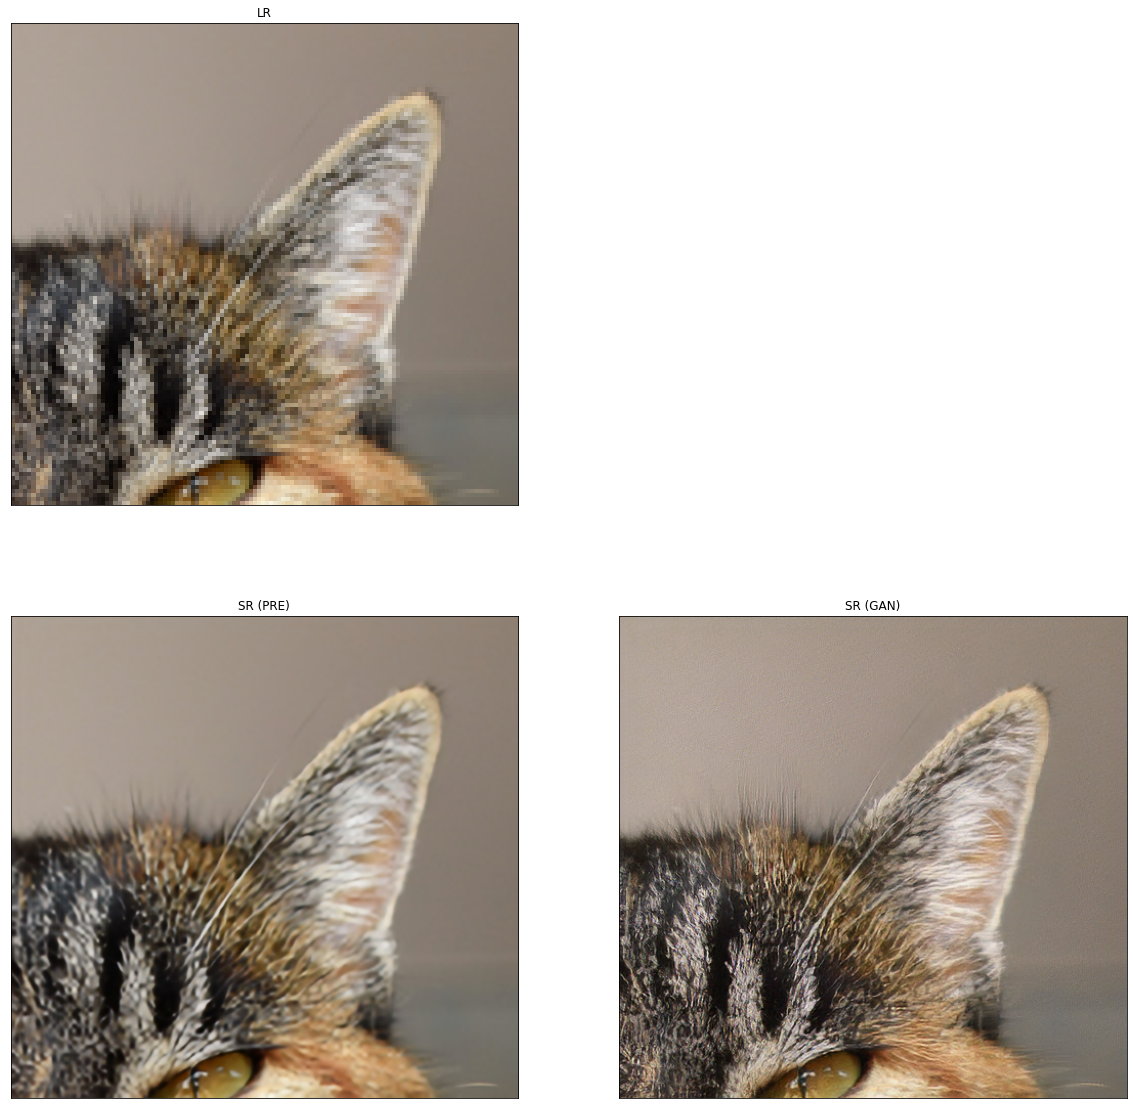

In [23]:
resolve_and_plot('demo/0869x4-crop.png')